## Thumbnail extraction demo

This example demonstrated the procedure for the extraction of query relevant thumbnails from a videos. The inputs to the model are a text query and the url of a video. The model outputs the top 5 query relevant frames from the video, suitable as video thumbnails. The model comprises of a CNN for image feature extraction and a LSTM network for query modelling. We provide the learned weights for the model trained using MSR Clickture dataset as well as the RAD dataset.

The implementation is using Lasagne and Theano.
For more details about the work, please refer to:
"Query-adaptive Video Summarization via Quality-aware Relevance Estimation"- ACM Multimedia 2017

### To start with:

Install the package: qvsumm

```
pip install requirements.txt
python setup.py install --user
```


In [1]:
### Download the trained weights of the models ###
import os
if not os.path.exists('data/vgg19.pkl'):
    !wget -P ./data/ https://data.vision.ee.ethz.ch/arunv/qv_summary_codes/vgg19.tar.gz -nc
    !tar -xzvf ./data/vgg19.tar.gz -C ./data/ --skip-old-files
    !rm ./data/vgg19.tar.gz
!wget -P ./data/ https://data.vision.ee.ethz.ch/arunv/qv_summary_codes/CNNmodel.npz -nc
!wget -P ./data/ https://data.vision.ee.ethz.ch/arunv/qv_summary_codes/LSTMmodel.npz -nc
'''
Warning: The model below is of 10G. This is complete version. May take some time to download and unzip. 
For a smaller model, comment this and use the commented model further below.
'''
!wget -P ./data/ https://data.vision.ee.ethz.ch/arunv/qv_summary_codes/word2vecmodel.tar.gz -nc
!mkdir ./data/word2vec
!tar -xzvf ./data/word2vecmodel.tar.gz -C ./data/word2vec/ --skip-old-files

## Small model, Use below one: This has a memory of 3.5G ##

#!wget -P ./data/word2vec/ https://data.vision.ee.ethz.ch/arunv/qv_summary_codes/GoogleNews-vectors-negative300.bin -nc

File ‘./data/CNNmodel.npz’ already there; not retrieving.

File ‘./data/LSTMmodel.npz’ already there; not retrieving.

File ‘./data/word2vecmodel.tar.gz’ already there; not retrieving.

mkdir: cannot create directory ‘./data/word2vec’: File exists
word2vecnewsmodelfull300
tar: word2vecnewsmodelfull300: skipping existing file
word2vecnewsmodelfull300.syn0.npy
tar: word2vecnewsmodelfull300.syn0.npy: skipping existing file
word2vecnewsmodelfull300.syn1neg.npy
tar: word2vecnewsmodelfull300.syn1neg.npy: skipping existing file


In [2]:
### Import our package ###
import qvsumm

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5105)


Loaded config file from qvsumm/config.ini
Loaded config file from qvsumm/config.ini


In [3]:
'''
Set and compile the score function
On the GPU, the network will be using cuDNN layer implementations available in the Lasagne.

'''
score_function = qvsumm.get_QAR_function()

Load weights and compile Relevance model...
Set LSTM learned weights...
Set CNN learned weights...


In [4]:
### Load the word2vec model ###
w2vmodel = qvsumm.get_word2vec_function()

Load word2vec model...


In [5]:
# Inputs : Text query and YouTube URL of the video
videoURL="https://www.youtube.com/watch?v=ntza_9lbbc0"
query="cat fail"

In [6]:
# Preprocessing Data
from qvsumm.utils_func import preprocess_video
imagenames= preprocess_video(query,videoURL)

/home/ubuntu/.local/lib/python2.7/site-packages/skimage/filter/__init__.py:6: skimage_deprecation: The `skimage.filter` module has been renamed to `skimage.filters`.  This placeholder module will be removed in v0.13.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '
/usr/local/lib/python2.7/dist-packages/moviepy-0.2.2.13-py2.7.egg/moviepy/video/io/ffmpeg_reader.py:135: UserWarning: Warning: in file videos/cat fail.mp4, 691200 bytes wanted but 0 bytes read,at frame 1753/1754, at time 58.49/58.51 sec. Using the last valid frame instead.
  UserWarning)


In [7]:
### Compute the scores for all the frames of the video ###
scores,_=qvsumm.get_rel_Q_scores(score_function, w2vmodel, query, imagenames)  

Scoring frames... 


In [8]:
### Set the K of top-K and bottom-K videoframes ###
K=5

In [9]:
indices=sorted(range(len(scores)), key=lambda k: scores[k],reverse=True)
print [scores[indices[i]]  for i in range(K)]

[0.73164201, 0.73122066, 0.72498858, 0.71302783, 0.67962474]


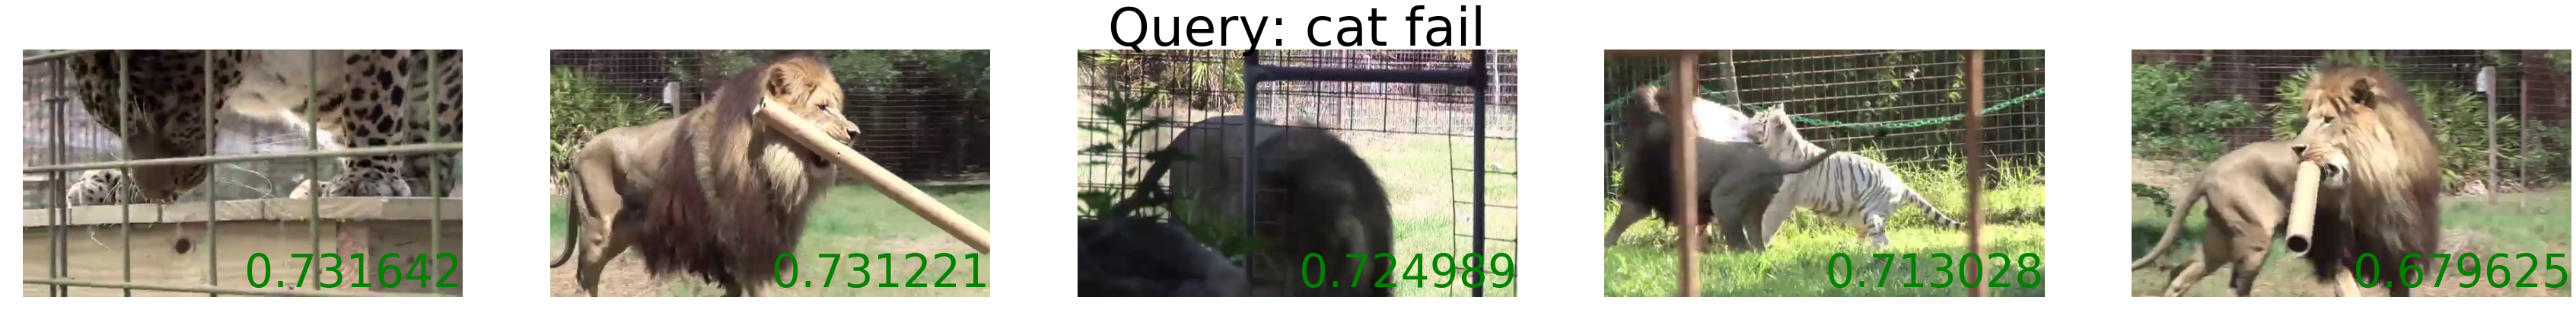

In [10]:
'''
We extract the top 5 frames from the video based on their scores. Higher the score, higher the relevance.
'''
import matplotlib .pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
plt.figure(figsize=(60, 10))
for enum,i in enumerate(indices[0:K]):
    if enum==3:
        plt.title("Query: "+str(query),fontsize=70)
    plt.subplot(1,K, enum+1);plt.imshow(mpimg.imread("videos/frames/"+str(i)+".png"));plt.axis('off')
    plt.annotate(str(scores[i]), xy=(1, 0), xycoords='axes fraction', fontsize=60,
    horizontalalignment='right', verticalalignment='bottom',color='green')
plt.show()

These are the highly scored frames (Top-5) of the video based on their relevance to the query.
The Green numbers on the images are the relevance scores from our model. 

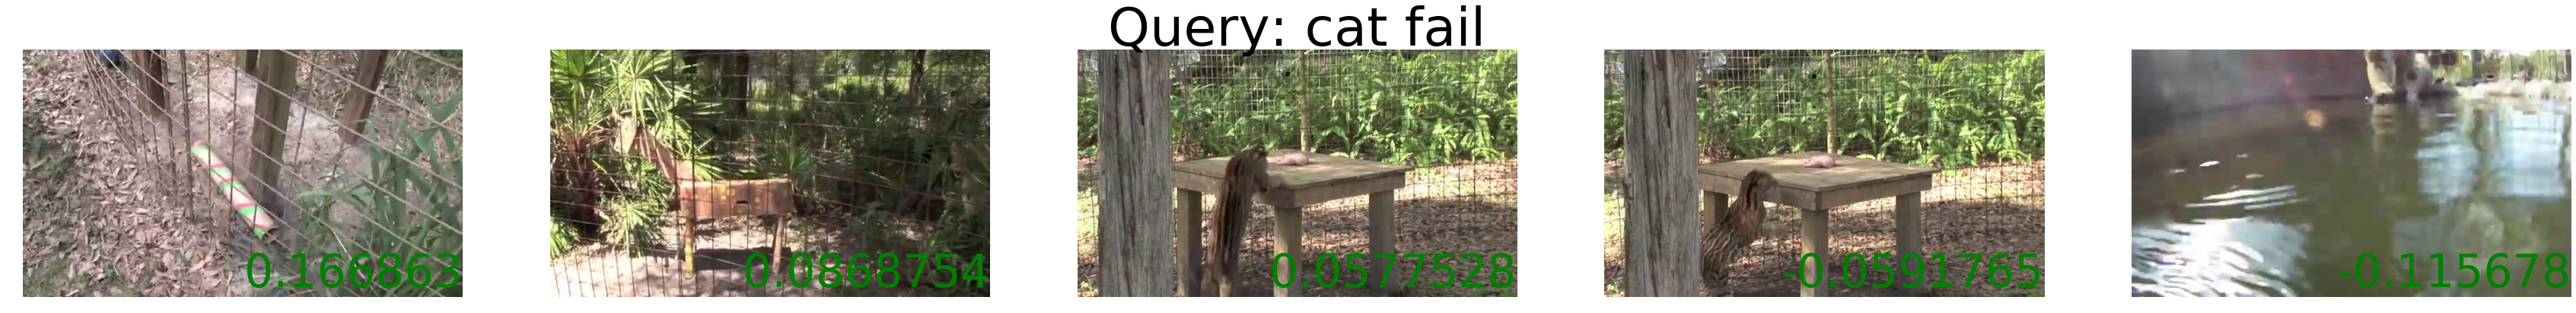

In [11]:
'''
We extract the bottom 5 frames from the video. They are supposed to be relatively bad thumbnails for the video.
'''
plt.figure(figsize=(60, 10))
for enum,i in enumerate(indices[len(indices)-K:len(indices)]):
    if enum==3:
        plt.title("Query: "+str(query),fontsize=70)
    plt.subplot(1,K, enum+1);plt.imshow(mpimg.imread("videos/frames/"+str(i)+".png"));plt.axis('off')
    plt.annotate(str(scores[i]), xy=(1, 0), xycoords='axes fraction', fontsize=60,
    horizontalalignment='right', verticalalignment='bottom',color='green')
plt.show()

These are the low scored frames (Bottom-5) of the video based on their relevance to the query.